# TTU_Sticknet Analysis
- Author: Hamid
- Date created: Jan 21, 2023
- Date Modified: Jan 26, 2023

## Instructions:
- Define the desired IOP in a variable named `event` and the `probeID` as `"IOP1"` & `"0101A"` respectively.
- Carefully review and verify all time, units, and other parameters before proceeding.
- Note that the functions for calculating thermodynamic parameters and plotting belongs to Jessie McDonald and are located at GitHub repo https://github.com/jessmcd/StickNet_Repo/

### Importing necessary packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

### Setup base directory as `basedir`

In [2]:
basedir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/TTU_StickNet/"

In [3]:
event = "IOP1"
probeID = "0101A"

files = glob.glob(f"{basedir}/{probeID}_{event}_level3.txt")
config_files = glob.glob(f"{basedir}*{event}*.csv")

matching_file = next(filter(lambda x: event in x, files), None)
if matching_file:
    probe_id = matching_file.split(os.sep)[-1].split("_")[0]
    print(probe_id, event)
    df = pd.read_csv(matching_file)
    df['Time'] = pd.DatetimeIndex(df['Time'])
    df.set_index("Time", inplace=True)
#     df["WSMAX"] = df["WS"].rolling(window=3, min_periods=1).max()
    matching_config = next(filter(lambda x: event in x, config_files), None)
    if matching_config:
        config = pd.read_csv(matching_config)
        match_config_row = config[config['ID'] == probe_id[1:]]
        if match_config_row.empty:
            print(f"No config row matching probe_id {probe_id} was found.")
        else:
            df.attrs = match_config_row.to_dict(orient='records')[0]
            print(df.attrs)
    else:
        print(f"No config file matching event {event} was found.")
else:
    print(f"No file matching event {event} was found.")

0101A IOP1
{'ID': '101A', 'Latitude': 33.145617, 'Longitude': -89.064152, 'Elevation': 182.2, 'Array_Type': 'Coarse'}


In [4]:
df.head()

,T,RH,P,WS,WD
Time,,,,,
2022-03-21 16:20:00,20.1,32.2,1001.9,4.8,134.0
2022-03-21 16:20:01,20.1,31.9,1001.9,5.6,137.6
2022-03-21 16:20:02,20.1,31.7,1001.8,6.8,143.5
2022-03-21 16:20:03,20.1,31.5,1001.8,6.7,128.6
2022-03-21 16:20:04,20.1,31.4,1001.8,5.7,131.7


In [5]:
display(df.tail())

,T,RH,P,WS,WD
Time,,,,,
2022-03-23 16:24:04,9.7,75.7,989.3,3.0,255.2
2022-03-23 16:24:05,9.7,75.6,989.4,2.9,246.9
2022-03-23 16:24:06,9.7,75.5,989.4,2.8,242.5
2022-03-23 16:24:07,9.7,75.4,989.4,2.9,249.6
2022-03-23 16:24:08,9.6,75.4,989.4,2.8,243.9


In [6]:
df.describe()

,T,RH,P,WS,WD
count,172901.000000,172901.000000,172901.000000,172604.000000,172604.000000
mean,16.225146,70.096924,989.993347,3.246428,166.208759
std,3.590360,25.722952,4.711027,1.581568,48.571255
min,9.200000,24.100000,983.000000,0.000000,2.600000
25%,15.100000,44.100000,985.600000,2.100000,132.200000
50%,15.900000,75.200000,989.000000,3.000000,148.700000
75%,17.900000,94.100000,993.900000,4.200000,206.700000
max,23.300000,100.000000,1001.900000,13.100000,355.600000


In [7]:
def make_averaged_file(data, sampling_interval='60s'):
    '''
    data:                 pandas DataFrame of StickNet data
    sampling_interval:    a time interval that can be accepted by pandas resample function. Examples
                          include 1Min, 1s, 100ms, etc
                          
    This function averages data at whatever sampling interval was specified. A pandas DataFrame of the 
    averaged data is returned. 
    '''
   
    # variables
    avg_temp = np.round(data['T'].resample(sampling_interval, label='right').mean(),1)
    avg_P =    np.round(data['P'].resample(sampling_interval, label='right').mean(),1)
    avg_RH =   np.round(data['RH'].resample(sampling_interval, label='right').mean(),1)
    avg_ws =   np.round(data['WS'].resample(sampling_interval, label='right').mean(),1)
    times = avg_P.index
    
    # wind direction NOTE: can't do normal averaging for this, must break into u and v
    u,v = convert_wind(data['WS'], data['WD'])
    u_avg = u.resample(sampling_interval, label='right').mean()
    v_avg = v.resample(sampling_interval, label='right').mean()
    avg_wd = np.round(np.rad2deg(np.arctan2(u_avg, v_avg))+180,1) # rotate so 0 is N
    
    # max 3 second average wind gust
    max_3sec_gust = np.round(data['WS'].rolling('3s').mean().resample('1Min', label='right').max(),1)
    
#     # if 10Hz data used in a minute has been flagged, the whole minute will be flagged
#     # if data looks wonky, checking this number may explain why
#     tflag = data['TFLAG'].resample(sampling_interval, label='right').max()
#     wflag = data['WFLAG'].resample(sampling_interval, label='right').max()
    
#     # battery 
#     batt = np.round(data['batt'].resample(sampling_interval, label='right').mean())

    # put data into pandas dataframe
#     d = {'T':avg_temp, 'RH':avg_RH, 'P':avg_P, 'WS':avg_ws, 'WSMAX':max_3sec_gust, 
#          'WD':avg_wd, 'BATT':batt, 'TFLAG':tflag, 'WFLAG':wflag}
    d = {'T':avg_temp, 'RH':avg_RH, 'P':avg_P, 'WS':avg_ws, 'WSMAX':max_3sec_gust, 
     'WD':avg_wd,}
    avgmet = pd.DataFrame(data=d,index=times).replace(-999.9,np.nan)
    avgmet.sort_index(ascending = True, inplace = True)
    avgmet.attrs = data.attrs
    
    return avgmet

In [8]:
#################
# Functions used
#################

import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
#import probe_info
import pandas as pd
import subprocess as sp
import os

def get_winddir_string(ws):
    if ws >= 0.0 and ws < 22.5:
        return 'N'
    elif ws >= 22.5 and ws < 67.5:
        return 'NE'
    elif ws >= 67.5 and ws < 112.5:
        return 'E'
    elif ws >= 112.5 and ws < 157.5:
        return 'SE'
    elif ws >= 157.5 and ws < 202.5:
        return 'S'
    elif ws >= 202.5 and ws < 247.5:
        return 'SW'
    elif ws >= 247.5 and ws < 292.5:
        return 'W'
    elif ws >= 292.5 and ws < 337.5:
        return 'NW'
    else:
        return 'N'


def calc_thetae(T,Td,P):
    """ Calculate equivalent potential temperature from Bolton (1980)
    Inputs: Temperature (T, celcius), Dewpoint (Td, celcius) and Station Pressure (P, hPa)
    Output: Equivalent Potential Temperature (theta_e, Kelvin) """
    e = 6.11*(10**((7.5*Td)/(237.3+Td)))                              # vapor pressure, uses degrees C
    w = 0.622 * e/(P-e)                                               # mixing ratio, uses hPa for pressure variables
    T_K,Td_K = T + 273.15,Td + 273.15                                 # convert T and Td to Kelvin
    Tl = 1.0/(1.0/(Td_K-56.0) + np.log(T_K/Td_K)/800.0) + 56.0        # approximated temperature at LCL (Kelvin)
    theta_l = T_K * ((1000.0/(P-e))**0.2854) * (T_K/Tl)**(0.28*w)     # dry potential temperature at LCL (Kelvin)
    theta_e = theta_l * np.exp(((3036.0/Tl)-1.78)*w*(1.0+0.448*w))    # equivalent potential temp (Kelvin)
    return theta_e

def calc_thetav(T,Td,P):
    """ Calculate theta v from Bolton (1980)
    theta_v = theta (1+0.61w)
    Inputs: Temperature (T, celcius), Dewpoint (Td, celcius), Station Pressure (P, hPa)"""
    e = 6.11*(10**((7.5*Td)/(237.3+Td)))
    w = 0.622 * e/(P-e)
    kappa = 2/7.
    theta = (T+273.15)*((1000/P)**kappa)
    theta_v = theta*(1+0.61*w)
    return theta_v

def convert_wind(ws,dir):
    """ convert wind speed to u and v components (in knots) for plotting wind barbs """
    new_dir = 270-dir
    u = (ws*1.94384)*np.cos(new_dir * np.pi/180)
    v = (ws*1.94384)*np.sin(new_dir * np.pi/180)
    return u,v

# calc station pressure from MSLP, T, H
def calc_station_pressure(p_slp,t,h):
    """ p_slp in mb, t in K, h in meters """
    return p_slp * np.exp(-h/(t+29.263))

def alt_to_mb(mm):
    return mm*33.8637526

def calc_dewpoint(T,RH):
    RH = np.ma.masked_values(RH,-999.9)
    num = np.log(RH/100) + (17.625*T)/(243.04+T)
    denom = 17.625 - np.log(RH/100) - (17.625*T)/(243.04+T)
    return 243.04*num/denom

def calc_windchill(T,V):
    """ Temperature in fahrenheit and wind speed V in miles per hour"""
    return 35.74 + 0.6215*T - 32.75*(V**0.16) + 0.4275*T*(V**0.16)

def calc_heatindex(T,RH):
    """ Temperature in fahrenheit and relative humidity in percent """
    line1 = -42.379 + (2.04901523*T) + (10.14333127*RH)
    line2 = (0.22475541 * T * RH) + (6.83783 * 10**-3 * T**2)
    line3 = (5.481717*10**-1 * RH**2) - (1.22874 * 10**-3 * T**2 * RH)
    line4 = (8.5282*10**-4 * T * RH**2) - (1.99*10**-6 * T**2 * RH**2)
    return line1-line2-line3+line4

def calc_mslp(T,P,h):
    return P*(1-(0.0065*h)/(T+0.0065*h+273.15))**(-5.257)

def C_to_F(temp):
    return np.round(temp*1.8 + 32,decimals=1)

def parse_currtime():
    """ parse the current datetime, in datetime format, to a specific string format for titles """
    currtime = dt.datetime.utcnow()
    #year = currtime.strftime("%Y")
    #month = currtime.strftime("%m")
    #day = currtime.strftime("%d")
    #hour = currtime.strftime("%H")
    #min = currtime.strftime("%M")
    #return "{0}-{1}-{2} {3}:{4} UTC".format(year,month,day,hour,min),currtime.strftime("%Y%m%d%H%M")
    return currtime.strftime("%Y-%m-%d %H:%M UTC"),currtime.strftime("%Y%m%d_%H%M")


# Make meteogram plot
def plot_meteogram(met, probe_id, savedir):
    ''' 
    Plots the meteogram of a single sticknet. Accepts any length of time,
    but is designed to look best for 24 hour periods. 
    -----------
    Inputs:
    met       - a pandas dictionary containing Temp ['T'], RH ['RH'], Pressure ['P'],
                windspeed ['WS'], 3 second wind gust ['WSMAX'], and wind dir ['WD'] 
                for a single StickNet.
    Elevation - the Elevation in meters of the Sticknet. Used to calculated 
                MSLP, ThetaE, and ThetaV
    probe_id  - 4 letter/number station identifier.
    -----------
    outputs: N/A. Saves meteogram to hardcoded location with hardcoded date in name. 
             Edit this for post-processing.  
    Upgraded J. McDonald 2021. 
    '''

    # pull and format data
    Elevation = met.attrs['Elevation']
    tempf     = C_to_F(met['T'].values)
    dewp      = calc_dewpoint(met['T'].values,met['RH'].values)
    dewpf     = C_to_F(dewp)
    thetae    = calc_thetae(met['T'].values, dewp, met['P'].values)
    thetav    = calc_thetav(met['T'].values, dewp, met['P'].values)
    mslp      = calc_mslp(met['T'].values,met['P'].values, Elevation)
    dates     = pd.to_datetime(met.index)
    ws        = met['WS']*1.94384     # convert from m/s to kt
    ws3sec    = met['WSMAX']*1.94384  # convert from m/s to kt
    wd        = met['WD']
    RH        = met['RH']


    # set up fontsizes 
    plt.rc('xtick',labelsize=11)
    plt.rc('ytick',labelsize=13)
    
    # set up figure
    fig, axes = plt.subplots(5, figsize = (12,18))
    top_anchor = 1.15 # changes title/legend relation to their plot
    lfs = 13 # legend fontsize
    ylfs = 14 # ylable fontsize
    ec = '0.5' # color of legend outline. default is 0.8


    # plot wind direction and speed

    axes[0].set_ylim(0,max(ws3sec)+2)
    axes[0].plot(dates,ws,color='#57858c',alpha = 0.5, linewidth=1)
    ln1 = axes[0].fill_between(dates,ws,plt.ylim()[0],color='#57858c',alpha = 0.5,label='Wind Speed')
    ln2 = axes[0].scatter(dates, ws3sec, marker='s', color = '#655978', 
                          s=1.2, alpha=0.5, label='3-sec Gust', zorder=0)
    axes[0].set_ylabel('Wind Speed\n(knots)', multialignment='center',fontsize = ylfs)

    ax0 = axes[0].twinx()
    ln3 = ax0.plot(dates,wd,'.k', alpha = 0.8, markersize=3, label='Wind Direction')
    ax0.set_ylim(0,360)
    ax0.set_ylabel('Wind Direction\n(degrees)', multialignment='center',fontsize=ylfs)
    ax0.set_yticks(np.arange(45,405,90))
    ax0.set_yticklabels(['NE','SE','SW','NW'])

    lns = [ln1,ln2,ln3[0]] 
    labs = [l.get_label() for l in lns]
    ax0.legend(lns, labs, loc='upper left', markerscale=5,
               bbox_to_anchor=(0.005,top_anchor),ncol=3,prop={'size':lfs},framealpha=1,edgecolor=ec)


    # plot temp and dewpoint and RH

    ymax,ymin = (max(tempf)+3,min(dewpf)-3)
    axes[1].set_ylim(ymin,ymax)
    axes[1].set_ylabel('Temperature\n(F)', multialignment='center',fontsize = ylfs)
    ln1=axes[1].fill_between(dates,tempf,dewpf,color = '#a83939',alpha = 0.6, label = 'Temperature') 
    ln2=axes[1].fill_between(dates,dewpf,plt.ylim()[0],color = '#207849', alpha = 0.7,label = 'Dewpoint')

    ax1 = axes[1].twinx()
    ln3 = ax1.plot(dates,RH,color='#2b0000', linewidth=3,alpha=0.5, label='Relative Humidity')
    ax1.set_ylim(0,103)
    ax1.set_ylabel('Relative Humidity\n(%)',multialignment='center',fontsize = ylfs)
    lns = [ln1,ln2, ln3[0]] 
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='upper left', 
               bbox_to_anchor=(0.005,top_anchor),ncol=3,prop={'size':lfs},framealpha=1,edgecolor=ec)


    # MSLP

    axes[2].plot(dates,mslp,color = '#E37609',linewidth=3,alpha = 0.8,label='Mean Sea Level Pressure')
    ymax,ymin = np.round(np.max(mslp))+1,np.round(np.min(mslp))-1
    axes[2].set_ylim(ymin,ymax)
    axes[2].set_ylabel('Mean Sea Level\nPressure (hPa)', multialignment='center',fontsize = ylfs)
    axes[2].legend(loc='upper left', bbox_to_anchor=(0.005,top_anchor),ncol=1,prop={'size':lfs},framealpha=1,
                  edgecolor=ec)


    # plot theta_v and theta_e

    ymax,ymin = (max(thetav)+2,min(thetav)-2)
    axes[3].set_ylim(ymin,ymax)
    ln1=axes[3].plot(dates,thetav, color = '#084b69',alpha = 0.7, linewidth=4,
                     label = r"${\theta_v}$")
    axes[3].set_ylabel(r'${\theta_v}$ (K)', multialignment='center',fontsize = ylfs)

    ax3 = axes[3].twinx()
    ymax,ymin = (max(thetae)+2,min(thetae)-2)
    ax3.set_ylim(ymin,ymax)
    ln2=ax3.plot(dates,thetae, color = '#508a50',alpha = 0.6,linewidth=3,
                 label = r"${\theta_e}$")
    ax3.set_ylabel(r'${\theta_e}$ (K)', multialignment='center',fontsize = ylfs)
    lns= [ln1[0],ln2[0]]
    labs=[l.get_label() for l in lns]
    ax3.legend(lns,labs,loc='upper left', bbox_to_anchor=(0.005,top_anchor),
               ncol=3,prop={'size':lfs},framealpha=1,edgecolor=ec)

    # theta_v gradient

    gradient = thetav[1:] - thetav[0:-1]

    axes[4].plot(dates[1:], gradient, color='#204e63',alpha=0.9,label=r"1-min ${\Delta\theta_v}$")
    axes[4].set_ylim(gradient.min()-1, gradient.max()+1)
    axes[4].set_ylabel(r'${\Delta\theta_v}$ (K/min)', multialignment='center',fontsize = ylfs)
    axes[4].legend(loc='upper left', bbox_to_anchor=(0.005,top_anchor),ncol=3,prop={'size':lfs},framealpha=1,
                  edgecolor=ec)
    axes[4].text(0.02, 0.1, 'Largest Decrease: {} K/min at {}'.format(np.round(min(gradient),2),
                dates[np.argmin(gradient)+1].strftime('%d/%H:%M UTC')), fontsize=14, color ='#204e63',
                 transform=axes[4].transAxes)

    #28264d the pretty purple color
    
    # number of hours rounded up
    length = np.ceil((dates[-1]-dates[0]).seconds/(60*60) + (dates[-1]-dates[0]).days*24)

    for ax in axes.flatten():
        
        # assign proper date formatting based on number of hours plotted
        if length > 8:
            ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M UTC'))
        else:
            ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M:%S UTC'))
            if length==5: # things look bad at this length for some reason
                ax.tick_params(labelsize=10)
                
            
        # set grids and things
        ax.grid(color='k', linestyle=':', linewidth=0.3, alpha=0.7)
        ax.set_xlim(dates.min(),dates.max()) # removes white space buffer

    # title              
    plt.suptitle('{}-Hour Meteogram for Station {}'.format(int(length), probe_id), fontsize = 18, 
                  x=0.135, y = .94, weight='bold', ha='left')
    axes[0].set_title('Latest Observation: {}'.format(dates[-1].strftime('%D %H:%M UTC')),
                      ha='left',x=0.015, y=1.21, fontsize=16)
    fig.subplots_adjust(hspace=0.35)


    # Plot the TTU logo
#     im = plt.imread("TTU_Logo.tif")
#     newax = fig.add_axes([0.04,0.87,0.07,0.07],anchor='NW',zorder=10)
#     newax.imshow(im, alpha=0.4)
#     newax.axis('off')

    # save figure 
    obtime = parse_currtime()[1] # note that this may be different from last time on plot
                                 # THATS OKAY... it will make data drops more apparent!
    #plt.savefig('{0}{1}_meteogram_{2}.png'.format(savedir,probe_id,obtime),dpi=300,bbox_inches = 'tight')
    
    # don't include obtime, because the meteograms get overwritten each time 
    # they'll get put in a separate directory for each day
    import pathlib
    pathlib.Path(savedir).mkdir(parents=True, exist_ok=True)
    plt.savefig('{0}{1}_meteogram.png'.format(savedir,probe_id,obtime),dpi=300,bbox_inches = 'tight')
    plt.show()
#     plt.close()

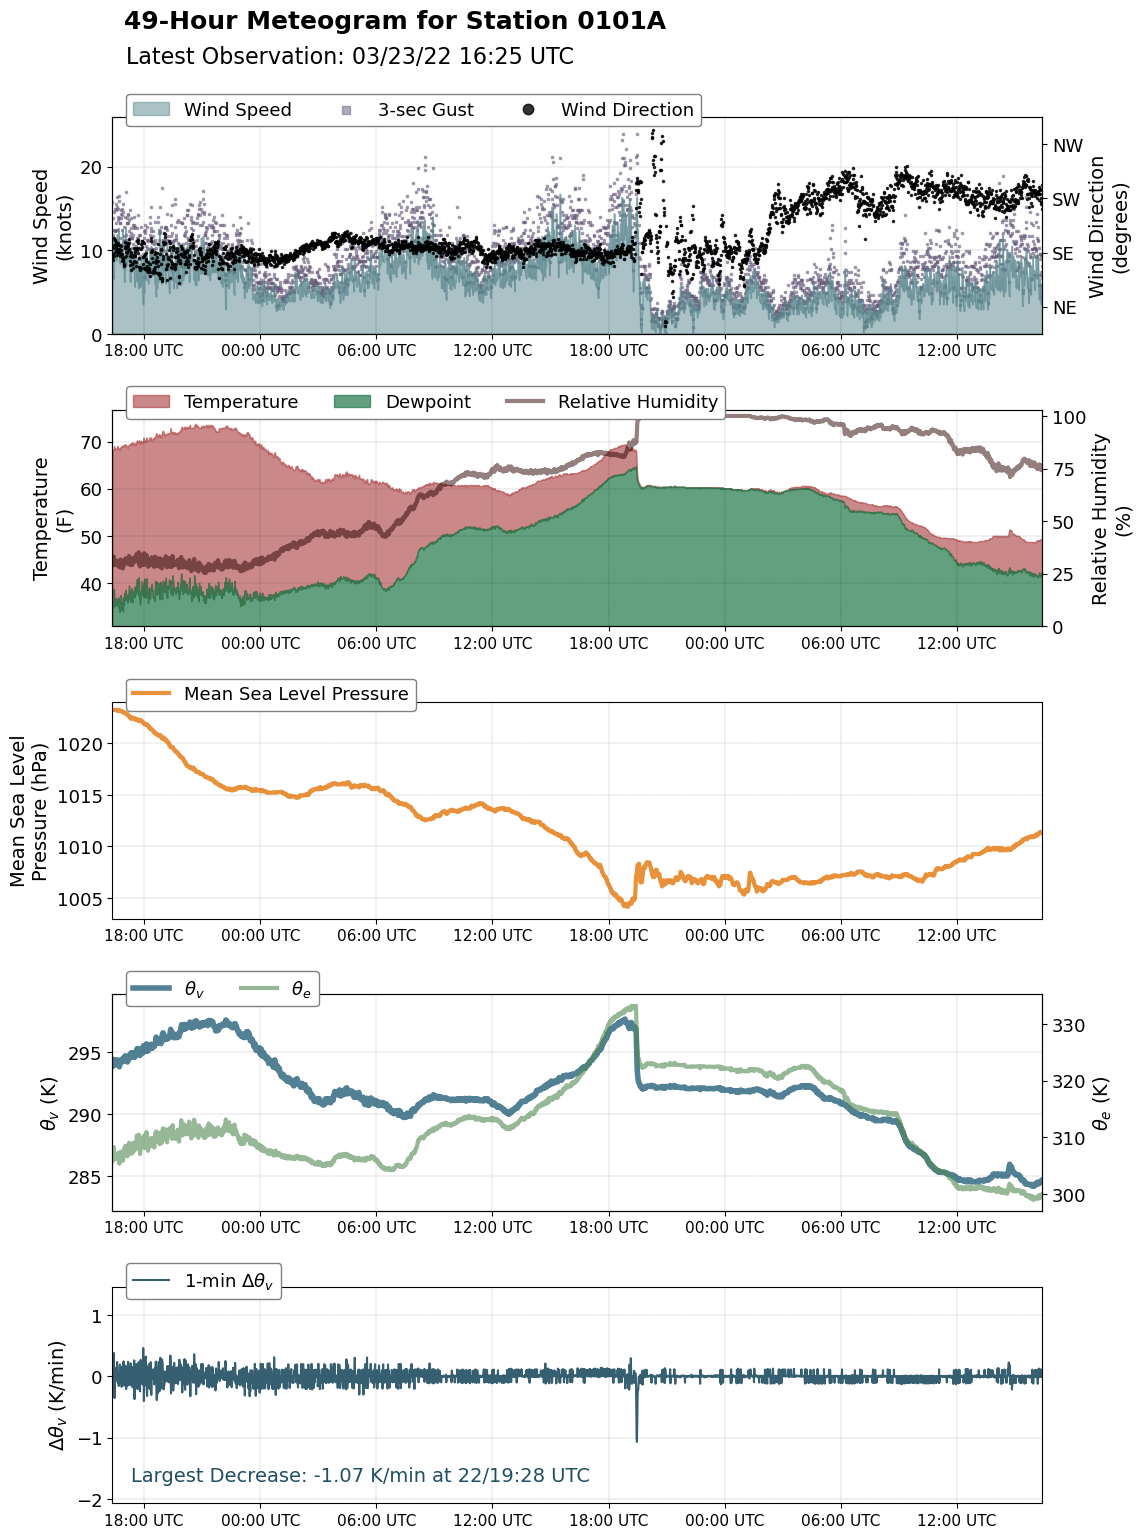

In [9]:
plot_meteogram(make_averaged_file(df.dropna(), sampling_interval="1Min"), probe_id=probe_id, 
               savedir="/depot/dawson29/data/Projects/PERiLS/obsdata/2022/TTU_plots/")

This code imports necessary packages such as pandas, glob, os, and matplotlib.pyplot. It sets the base directory as "basedir" and assigns the variables "event" and "probeID". Then, it uses the glob function to search for files in the base directory that match the pattern of "probeID_event_level3.txt" and saves the results in the "files" variable. It also searches for files that match the pattern of "event.csv" and saves the results in the "config_files" variable. Next, it uses the filter function and lambda function to find the first file in the "files" variable that contains the "event" string, and assigns it to the "matching_file" variable. If a matching file is found, it splits the file name to extract the probe id and prints it along with the event. It reads the matching file as a csv and adds a new column 'WSMAX' which is the rolling maximum of column 'WS' over a window of 3. Then, it finds the first file in the "config_files" variable that contains the "event" string, and assigns it to the "matching_config" variable. If a matching config is found, it reads the file as a csv and finds the row that matches the probe id. If a matching row is found, it adds the row as an attribute to the dataframe and prints it. If no matching file or config is found, it will print a message saying so.